In [1]:
import torch
from ltn_imp.automation.knowledge_base import KnowledgeBase

In [2]:
def predict(model, x):
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # No need to track gradients
        # Ensure x is a tensor and has the right dtype
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        elif x.dtype != torch.float32:
            x = x.float()
        
        # Forward pass through the model
        probs = model(x)
        
        # Apply binary classification threshold at 0.5
        preds = (probs > 0.5).float()
    return preds

def compute_accuracy(model, data_loader):
    correct = 0
    total = 0
    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for data, labels in data_loader:
            # Ensure data and labels are the correct dtype
            if not isinstance(data, torch.Tensor):
                data = torch.tensor(data, dtype=torch.float32)
            elif data.dtype != torch.float32:
                data = data.float()
            
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels, dtype=torch.float32)
            elif labels.dtype != torch.float32:
                labels = labels.float()
            
            # Get predictions
            preds = predict(model, data)
            
            # Squeeze predictions and labels to remove dimensions of size 1
            predicted_labels = preds.squeeze()
            true_labels = labels.squeeze()

            # Ensure the shapes match before comparison
            if predicted_labels.shape != true_labels.shape:
                true_labels = true_labels.view_as(predicted_labels)
            
            # Count correct predictions
            correct += (predicted_labels == true_labels).sum().item()
            total += true_labels.size(0)

    accuracy = correct / total if total > 0 else 0
    print(f"Correct: {correct}, Total: {total}, Accuracy: {accuracy:.4f}")
    return accuracy


In [3]:
kb = KnowledgeBase("binary_config.yaml")

In [5]:
compute_accuracy(kb.predicates["Classifier"], kb.loaders[0])

Correct: 29, Total: 100, Accuracy: 0.2900


0.29

In [6]:
kb.optimize(num_epochs=2001, log_steps=500)

['∀ x.(((y == pos) -> Classifier(x)))', '∀ x.(((y == neg) -> ~(Classifier(x))))']
Rule Outputs:  [tensor(0.5591, grad_fn=<RsubBackward1>), tensor(0.5101, grad_fn=<RsubBackward1>)]
Epoch 1/2001, Loss: 0.4660193920135498

['∀ x.(((y == pos) -> Classifier(x)))', '∀ x.(((y == neg) -> ~(Classifier(x))))']
Rule Outputs:  [tensor(0.6584, grad_fn=<RsubBackward1>), tensor(0.7519, grad_fn=<RsubBackward1>)]
Epoch 501/2001, Loss: 0.29851043224334717

['∀ x.(((y == pos) -> Classifier(x)))', '∀ x.(((y == neg) -> ~(Classifier(x))))']
Rule Outputs:  [tensor(0.6597, grad_fn=<RsubBackward1>), tensor(0.7537, grad_fn=<RsubBackward1>)]
Epoch 1001/2001, Loss: 0.2970626950263977

['∀ x.(((y == pos) -> Classifier(x)))', '∀ x.(((y == neg) -> ~(Classifier(x))))']
Rule Outputs:  [tensor(0.6598, grad_fn=<RsubBackward1>), tensor(0.7537, grad_fn=<RsubBackward1>)]
Epoch 1501/2001, Loss: 0.29698646068573

['∀ x.(((y == pos) -> Classifier(x)))', '∀ x.(((y == neg) -> ~(Classifier(x))))']
Rule Outputs:  [tensor(0.6598, 

In [7]:
compute_accuracy(kb.predicates["Classifier"], kb.loaders[0])

Correct: 95, Total: 100, Accuracy: 0.9500


0.95

## Computation Graph

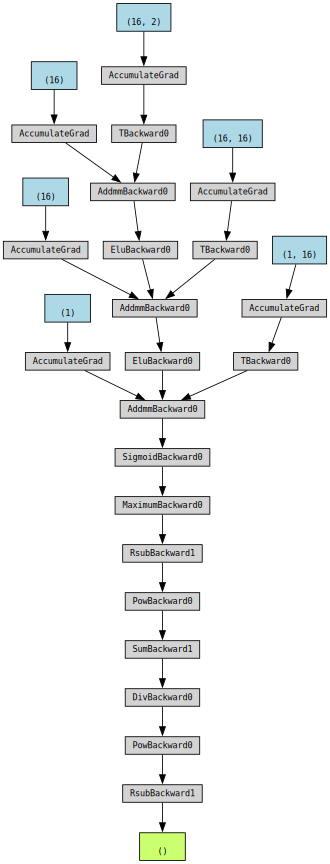

In [8]:
batch = next(iter(kb.loaders[0]))

var_mapping = {}

kb.partition_data(var_mapping,batch, kb.loaders[0])

kb.rules[0].comp_graph(var_mapping)